# DenseNet from Scratch in PyTorch

WIP

Densely Connected Convolutional Network (https://arxiv.org/abs/1608.06993)

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Define configs for different DenseNet versions

In [4]:
# densenet_= (number of DenseLayers in DenseBlocks)
model_hparameters= {}
model_hparameters['densenet121']= [6,12,24,16]
model_hparameters['densenet169']= [6,12,32,32]
model_hparameters['densenet201']= [6,12,48,32]
model_hparameters['densenet264']= [6,12,64,48]

growth_rate= 32
compression_factor= 2

# Architecture Implementation

**ConvLayer:** Implements a composite function that can optionally apply BatchNorm and ReLU before (or after) convolution.

In [5]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    DenseNet-style: Input -> BatchNorm2d -> ReLU -> Conv2d -> Output
    - norm_first: If True, applies Conv2d -> BatchNorm2d -> ReLU
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,
                 bias=False, activation=None, norm_first=True) -> None:
        super(ConvLayer, self).__init__()
        # Batch Normalization to stabilize training: if norm_first is True, apply BN on
        # the input; otherwise, apply on the output
        norm= nn.BatchNorm2d(in_channels) if norm_first else nn.BatchNorm2d(out_channels)
        # Activation function -- ReLU is the default in DenseNet
        activation= nn.ReLU() if activation is None else activation
        # Convolutional layer
        conv= nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, bias=bias
        )
        # Build the sequential conv layer
        if norm_first:
            self.layer= nn.Sequential(norm, activation, conv)
        else:
            self.layer= nn.Sequential(conv, norm, activation)


    def forward(self, x):

        return self.layer(x)


**DenseLayer:** Performs bottleneck operations (1x1 followed by 3x3 convolution) to produce new features. It returns only the new features.

In [6]:
class DenseLayer(nn.Module):
    """
    Implements one Bottleneck DenseLayer of DenseNet.
    This layer concatenates the input with the output.
    """

    def __init__(self, in_channels, growth_rate, bn_size=4, activation=None, dropout=0.1) -> None:
        super(DenseLayer, self).__init__()
        # Activation function -- ReLU is the default in DenseNet
        activation= nn.ReLU() if activation is None else activation

        # First convolution: bottleneck 1x1 conv to reduce dimensionality
        self.conv1= ConvLayer(
            in_channels, bn_size * growth_rate, kernel_size=1, stride=1, padding=0,
            bias=False, activation=activation
        )
        # Second convolution: 3x3 conv
        self.conv2= ConvLayer(
            bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1,
            bias=False, activation=activation
        )
        # Dropout layer for regularization
        self.dropout= nn.Dropout2d(p=dropout) if dropout> 0.0 else None


    def forward(self, x):
        # Ensure x is a list of feature tensors
        if isinstance(x, torch.Tensor):
            x= [x]
        # Concatenate features along the channel dimension
        out= torch.cat(x, dim=1)
        out= self.conv1(out)
        out= self.conv2(out)
        if self.dropout is not None:
            out= self.dropout(out)

        return out  # shape: [batch_size, growth_rate, H, W]


**DenseBlock:** Stacks multiple DenseLayers; at each layer, it concatenates the output of all preceding layers (including the original input) and passes it to the next DenseLayer.

In [7]:
class DenseBlock(nn.Module):
    """
    Implements one DenseBlock: a sequence of DenseLayers.
    Each DenseLayer receives as input the concatenation of all preceding layers' outputs.
    """

    def __init__(self, num_layers, in_channels, growth_rate, bn_size=4, activation=None,
                 dropout=0.1) -> None:
        super(DenseBlock, self).__init__()

        self.layers= nn.ModuleList([
            DenseLayer(in_channels + i * growth_rate, growth_rate, bn_size, activation, dropout)
            for i in range(num_layers)
        ])


    def forward(self, x):
        features= [x]
        for layer in self.layers:
            # Get new features from the current DenseLayer
            new_features= layer(features)
            # Append the new features to the list
            features.append(new_features)

        # Concatenate all features along the channel dimension
        return torch.cat(features, dim=1)


**TransitionLayer:** Reduces the number of channels via a 1x1 convolution and downsamples spatially using average pooling.

In [8]:
class TransitionLayer(nn.Module):
    """
    Implements one TransitionLayer.
    Uses a 1x1 convolution (with BN and ReLU) to reduce the number of channels
    (compression), followed by 2x2 average pooling to downsample the spatial resolution.
    """

    def __init__(self, in_channels, out_channels, activation=None, dropout=0.1) -> None:
        super(TransitionLayer, self).__init__()

        self.conv= ConvLayer(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0,
            bias=False, activation=activation
        )
        self.pool= nn.AvgPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        x= self.conv(x)
        x= self.pool(x)

        return x


# Building the DenseNet

Builds the overall model by stacking an initial convolutional layer (and max pooling), followed by DenseBlocks and TransitionLayers, finishing with a BatchNorm, activation, global average pooling, and a classification head.

In [9]:
class DenseNet(nn.Module):
    """
    DenseNet-BC model implementation.
    - An initial 7x7 convolution with max pooling.
    - Four DenseBlocks interleaved with TransitionLayers (except after the final block).
    - A final BatchNorm and activation.
    - Global average pooling and a fully connected layer for classification.
    """

    def __init__(self, model_version, in_channels, num_classes, growth_rate, bn_size=4,
                 compression_factor=2, activation=None, dropout=0.1) -> None:
        super(DenseNet, self).__init__()
        # Define the activation function -- ReLU is the default in DenseNet
        activation= nn.ReLU() if activation is None else activation

        # 7x7 convolution followed by max pooling
        self.conv_in= ConvLayer(
            in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False,
            activation=activation, norm_first=False  # Using Conv -> BN -> ReLU here
        )
        self.pool1= nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Initial number of channels after conv_in
        block_in_channels= 64

        # Add DenseBlocks and TransitionLayers
        self.dense_blocks= nn.ModuleList()
        for i, num_layers in enumerate(model_version):
            self.dense_blocks.append(
                DenseBlock(
                    num_layers, block_in_channels, growth_rate, bn_size, activation, dropout
                )
            )
            # Update the number of channels: each DenseLayer adds growth_rate channels
            block_in_channels += num_layers * growth_rate

            # Add a TransitionLayer between DenseBlocks (except after the last block) to downsample
            if i != len(model_version) - 1:
                self.dense_blocks.append(
                    TransitionLayer(
                        block_in_channels, block_in_channels // compression_factor, activation,
                        dropout
                    )
                )
                # Update the channel count after compression
                block_in_channels= block_in_channels // compression_factor

        # Final normalization and activation
        self.dense_blocks.append(nn.BatchNorm2d(block_in_channels))
        self.dense_blocks.append(activation)

        # Global average pooling and classification head to produce the class logits
        self.pool2= nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.head= nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(block_in_channels, num_classes),
        )

        # initialize parameters with Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x= self.conv_in(x)
        x= self.pool1(x)
        for block in self.dense_blocks:
            x= block(x)
        x= self.pool2(x)
        x= torch.flatten(x, start_dim=1)
        x= self.head(x)

        return x


In [10]:
img= torch.randn(1, 3, 224, 224).to(device)  # a single image batch
model= DenseNet(model_hparameters['densenet121'], in_channels=3, num_classes=1000,
                growth_rate=growth_rate, compression_factor=compression_factor).to(device)
count_parameters(model)
print(model(img).shape)

model

Number of parameters: 7978856
torch.Size([1, 1000])


DenseNet(
  (conv_in): ConvLayer(
    (layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dense_blocks): ModuleList(
    (0): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (conv1): ConvLayer(
            (layer): Sequential(
              (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): ReLU()
              (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
          (conv2): ConvLayer(
            (layer): Sequential(
              (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): ReLU()
              (2): Conv2d(128, 32, kernel_size=(3, 3), stri

# Training a DenseNet model from scratch

In [11]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [12]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 64.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:

- Data augmentation for training.
- Early Stopping: based on validation loss to prevent overfitting.
- Play with different activation functions.
- Play with different learning rate values.

In [14]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [15]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [16]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [17]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

# --- DenseNet-169 ---
in_channels= 3
num_classes= 10

model= DenseNet(model_hparameters['densenet169'], in_channels=3, num_classes=1000,
                growth_rate=growth_rate, compression_factor=compression_factor).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()

# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 14149480
Using fused AdamW: True


In [18]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 1.6240 | Val Loss: 1.3186 | dt/epoch: 116490.77ms
Epoch: 1 | Train Loss: 1.1196 | Val Loss: 0.9427 | dt/epoch: 114841.73ms
Epoch: 2 | Train Loss: 0.8927 | Val Loss: 0.8720 | dt/epoch: 114829.96ms
Epoch: 3 | Train Loss: 0.7359 | Val Loss: 0.6657 | dt/epoch: 114631.18ms
Epoch: 4 | Train Loss: 0.6226 | Val Loss: 0.5701 | dt/epoch: 114568.00ms
Epoch: 5 | Train Loss: 0.5342 | Val Loss: 0.5450 | dt/epoch: 114786.59ms
Epoch: 6 | Train Loss: 0.4722 | Val Loss: 0.4810 | dt/epoch: 114666.38ms
Epoch: 7 | Train Loss: 0.4247 | Val Loss: 0.4695 | dt/epoch: 115051.60ms
Epoch: 8 | Train Loss: 0.3829 | Val Loss: 0.4580 | dt/epoch: 114768.86ms
Epoch: 9 | Train Loss: 0.3526 | Val Loss: 0.4236 | dt/epoch: 114822.60ms
Epoch: 10 | Train Loss: 0.3224 | Val Loss: 0.3985 | dt/epoch: 114486.96ms
Epoch: 11 | Train Loss: 0.2895 | Val Loss: 0.4125 | dt/epoch: 115107.12ms
Epoch: 12 | Train Loss: 0.2665 | Val Loss: 0.3740 | dt/epoch: 114694.86ms
Epoch: 13 | Train Loss: 0.2442 | Val Loss: 0.349

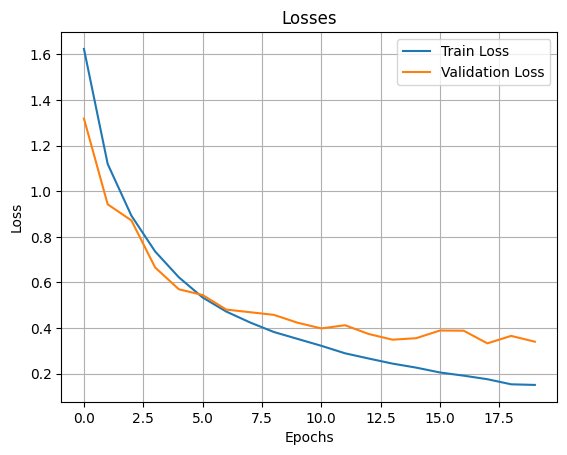

In [19]:
# plot
plot_losses(tr_loss, vl_loss)

In [20]:
densenet_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 88.75%


In [21]:
# https://medium.com/@karuneshu21/densenet-paper-walkthrough-764481fced3a
# https://medium.com/@karuneshu21/implement-densenet-in-pytorch-46374ef91900
# https://amaarora.github.io/posts/2020-08-02-densenets.html
# https://cdanielaam.medium.com/densenet-architecture-explained-with-code-examples-0d86d7936f83
# https://medium.com/deepkapha-notes/implementing-densenet-121-in-pytorch-a-step-by-step-guide-c0c2625c2a60
# https://medium.com/@rebirth4vali/implementing-densenet-bc-l-100-k-12-in-tensorflow-python-from-scratch-c8a5ffe942a2
# https://paperswithcode.com/method/densenet